## Navigation <a class="anchor" id="menu"></a>

#### Day 1

0. [Introduction](#intro)
1. [Import packages](#setup)
2. [Get the data](#data)
3. [Data exploration](#init_edit)
    
4. [Initial attempt at training](#train_first)
     
5. [Feature engineering](#feature_engineering)

6. [Bring everything together](#bring_together)
     
   
7. [Final training](#model)
    - [Overfitting model](#overfit)
    - [Final model](#final_model)

# 1. Import packages and define functions <a class="anchor" id="setup"></a>
[Back to top](#menu)

In [1]:
# !pip install jupyter_contrib_nbextensions
# !jupyter contrib nbextension install --user
# !jupyter nbextension enable codefolding/main

In [2]:
# necessary imports and functions
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import math
import random
from sklearn import preprocessing

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

pd.set_option('display.max_rows', 1000000)
pd.set_option('display.max_columns', 1000000)
matplotlib.rcParams.update({'font.size': 15})

def add_month_names(day):
    day_number = day%340
    if day_number<10:
        return 'February', 2
    elif day_number<40:
        return 'March', 3
    elif day_number<70:
        return 'April', 4
    elif day_number<100:
        return 'May', 5
    elif day_number<130:
        return 'June', 6
    elif day_number<160:
        return 'July', 7
    elif day_number<190:
        return 'August', 8
    elif day_number<220:
        return 'September', 9
    elif day_number<250:
        return 'October', 10
    elif day_number<280:
        return 'November', 11
    elif day_number<310:
        return 'December', 12
    elif day_number<340:
        return 'January', 1
    
def add_week_day_names(day):
    day_number = day%7
    if day_number==1:
        return 'Tuesday', day_number+1
    elif day_number==2:
        return 'Wednesday', day_number+1
    elif day_number==3:
        return 'Thursday', day_number+1
    elif day_number==4:
        return 'Friday', day_number+1
    elif day_number==5:
        return 'Saturday', day_number+1
    elif day_number==6:
        return 'Sunday', day_number+1
    elif day_number==0:
        return 'Monday', day_number+1
    
def get_season(month):
    if month == 'December' or month == 'January' or month == 'February':
        return 'winter'
    elif month == 'March' or month == 'April' or month == 'May':
        return 'spring'
    elif month == 'June' or month == 'July' or month == 'August':
        return 'summer'
    elif month == 'September' or month == 'October' or month == 'November':
        return 'fall'
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
   
def fill_nas_for_last_day(days_since_shopping):

    new_column = []
    days_since_column = days_since_shopping.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(days_since_column)):
        num_weeks = 1
        value = days_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(days_since_column):
                next_day_since_value = days_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(days_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = days_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= 7*num_weeks:
                    value = next_day_since_value-7*num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=days_since_shopping.index)

def fill_nas_for_spent_trip(amount_spent_last_trip):

    new_column = []
    amount_spent_last_trip_column = amount_spent_last_trip.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(amount_spent_last_trip_column)):
        amount = amount_spent_last_trip_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=amount_spent_last_trip.index)

def fill_nas_for_last_week(weeks_since_shopping):

    new_column = []
    weeks_since_column = weeks_since_shopping.tolist()
#     print(weeks_since_column)
#     print(len(weeks_since_column))
    
    next_day_since_value = 0
    
    for i in range(0,len(weeks_since_column)):
        num_weeks = 1
        value = weeks_since_column[i]
        
        if math.isnan(value):
            a = i+1
            if a<len(weeks_since_column):
                next_day_since_value = weeks_since_column[a]

                #get the next since value
                while math.isnan(next_day_since_value) and a<len(weeks_since_column)-1:
                    a = a+1
#                     print(a)
                    next_day_since_value = weeks_since_column[a]
                    num_weeks = num_weeks+1

                if next_day_since_value >= num_weeks:
                    value = next_day_since_value-num_weeks

            new_column.append(value)
    #             print('number of weeks: ' + str(num_weeks))
    #             print('instead of nan: ' + str(value))
            
        else:
#             print('*****' + str(value))
            new_column.append(value)
    
    return pd.Series(new_column, index=weeks_since_shopping.index)

def fill_nas_for_prev_trip(stats_column):

    new_column = []
    stats_column_list = stats_column.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(stats_column_list)):
        amount = stats_column_list[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=stats_column.index)

def fill_nas_for_weighted_avg(weighted_avg):

    new_column = []
    weighted_avg_column = weighted_avg.tolist()
#     print(days_since_column)
#     print(len(days_since_column))
    
    for i in range(0,len(weighted_avg_column)):
        amount = weighted_avg_column[i]
        
        if i == 0:
            new_column.append(amount)
            last_spent = amount
        else:
            if math.isnan(amount):
                new_column.append(last_spent)
            else:
                new_column.append(amount)
                last_spent = amount
    
    return pd.Series(new_column, index=weighted_avg.index)


# 2. Reading data <a class="anchor" id="data"></a>
[Back to top](#menu)

In [3]:
df_transactions = pd.read_csv('data/transactions.csv')
df_demographics = pd.read_csv('data/demographics.csv')
df_products = pd.read_csv('data/products.csv')
# old_promotions = pd.read_csv('time_on_app.csv')
df_promotions = pd.read_csv('data_new/promotions.csv')
df_campaigns = pd.read_csv('data/campaigns.csv')

# supporting_df =  pd.read_csv('supporting.csv')

print('Data loading complete!')

Data loading complete!


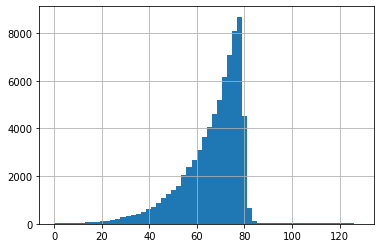

In [4]:
df_promotions['TIME_IN_APP'].hist(bins=60)

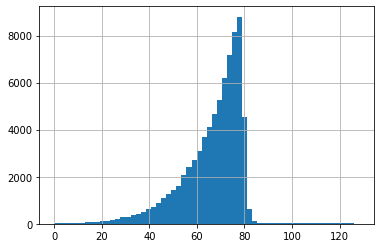

In [5]:
supporting_df['time_spent_on_app'].hist(bins=60)

# 3. Data exploration <a class="anchor" id="init_edit"></a>
[Back to top](#menu)

In [6]:
df_transactions.sort_values(['WEEK_NO','HOUSEHOLD_KEY']).head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT
404,5,1,77,3598272088,7.99,1.0,0.00
405,5,1,77,4744896796,7.99,1.0,0.00
406,5,1,77,5591447946,2.71,4.0,-2.75
407,5,1,77,6781602629,3.38,2.0,0.00
0,1,1,98,782443249,0.39,1.0,0.00


In [7]:
# all_households_sorted = df_transactions.sort_values('HOUSEHOLD_KEY')[['HOUSEHOLD_KEY']].drop_duplicates()
# print(all_households_sorted.shape)
# all_households_sorted.head(10)

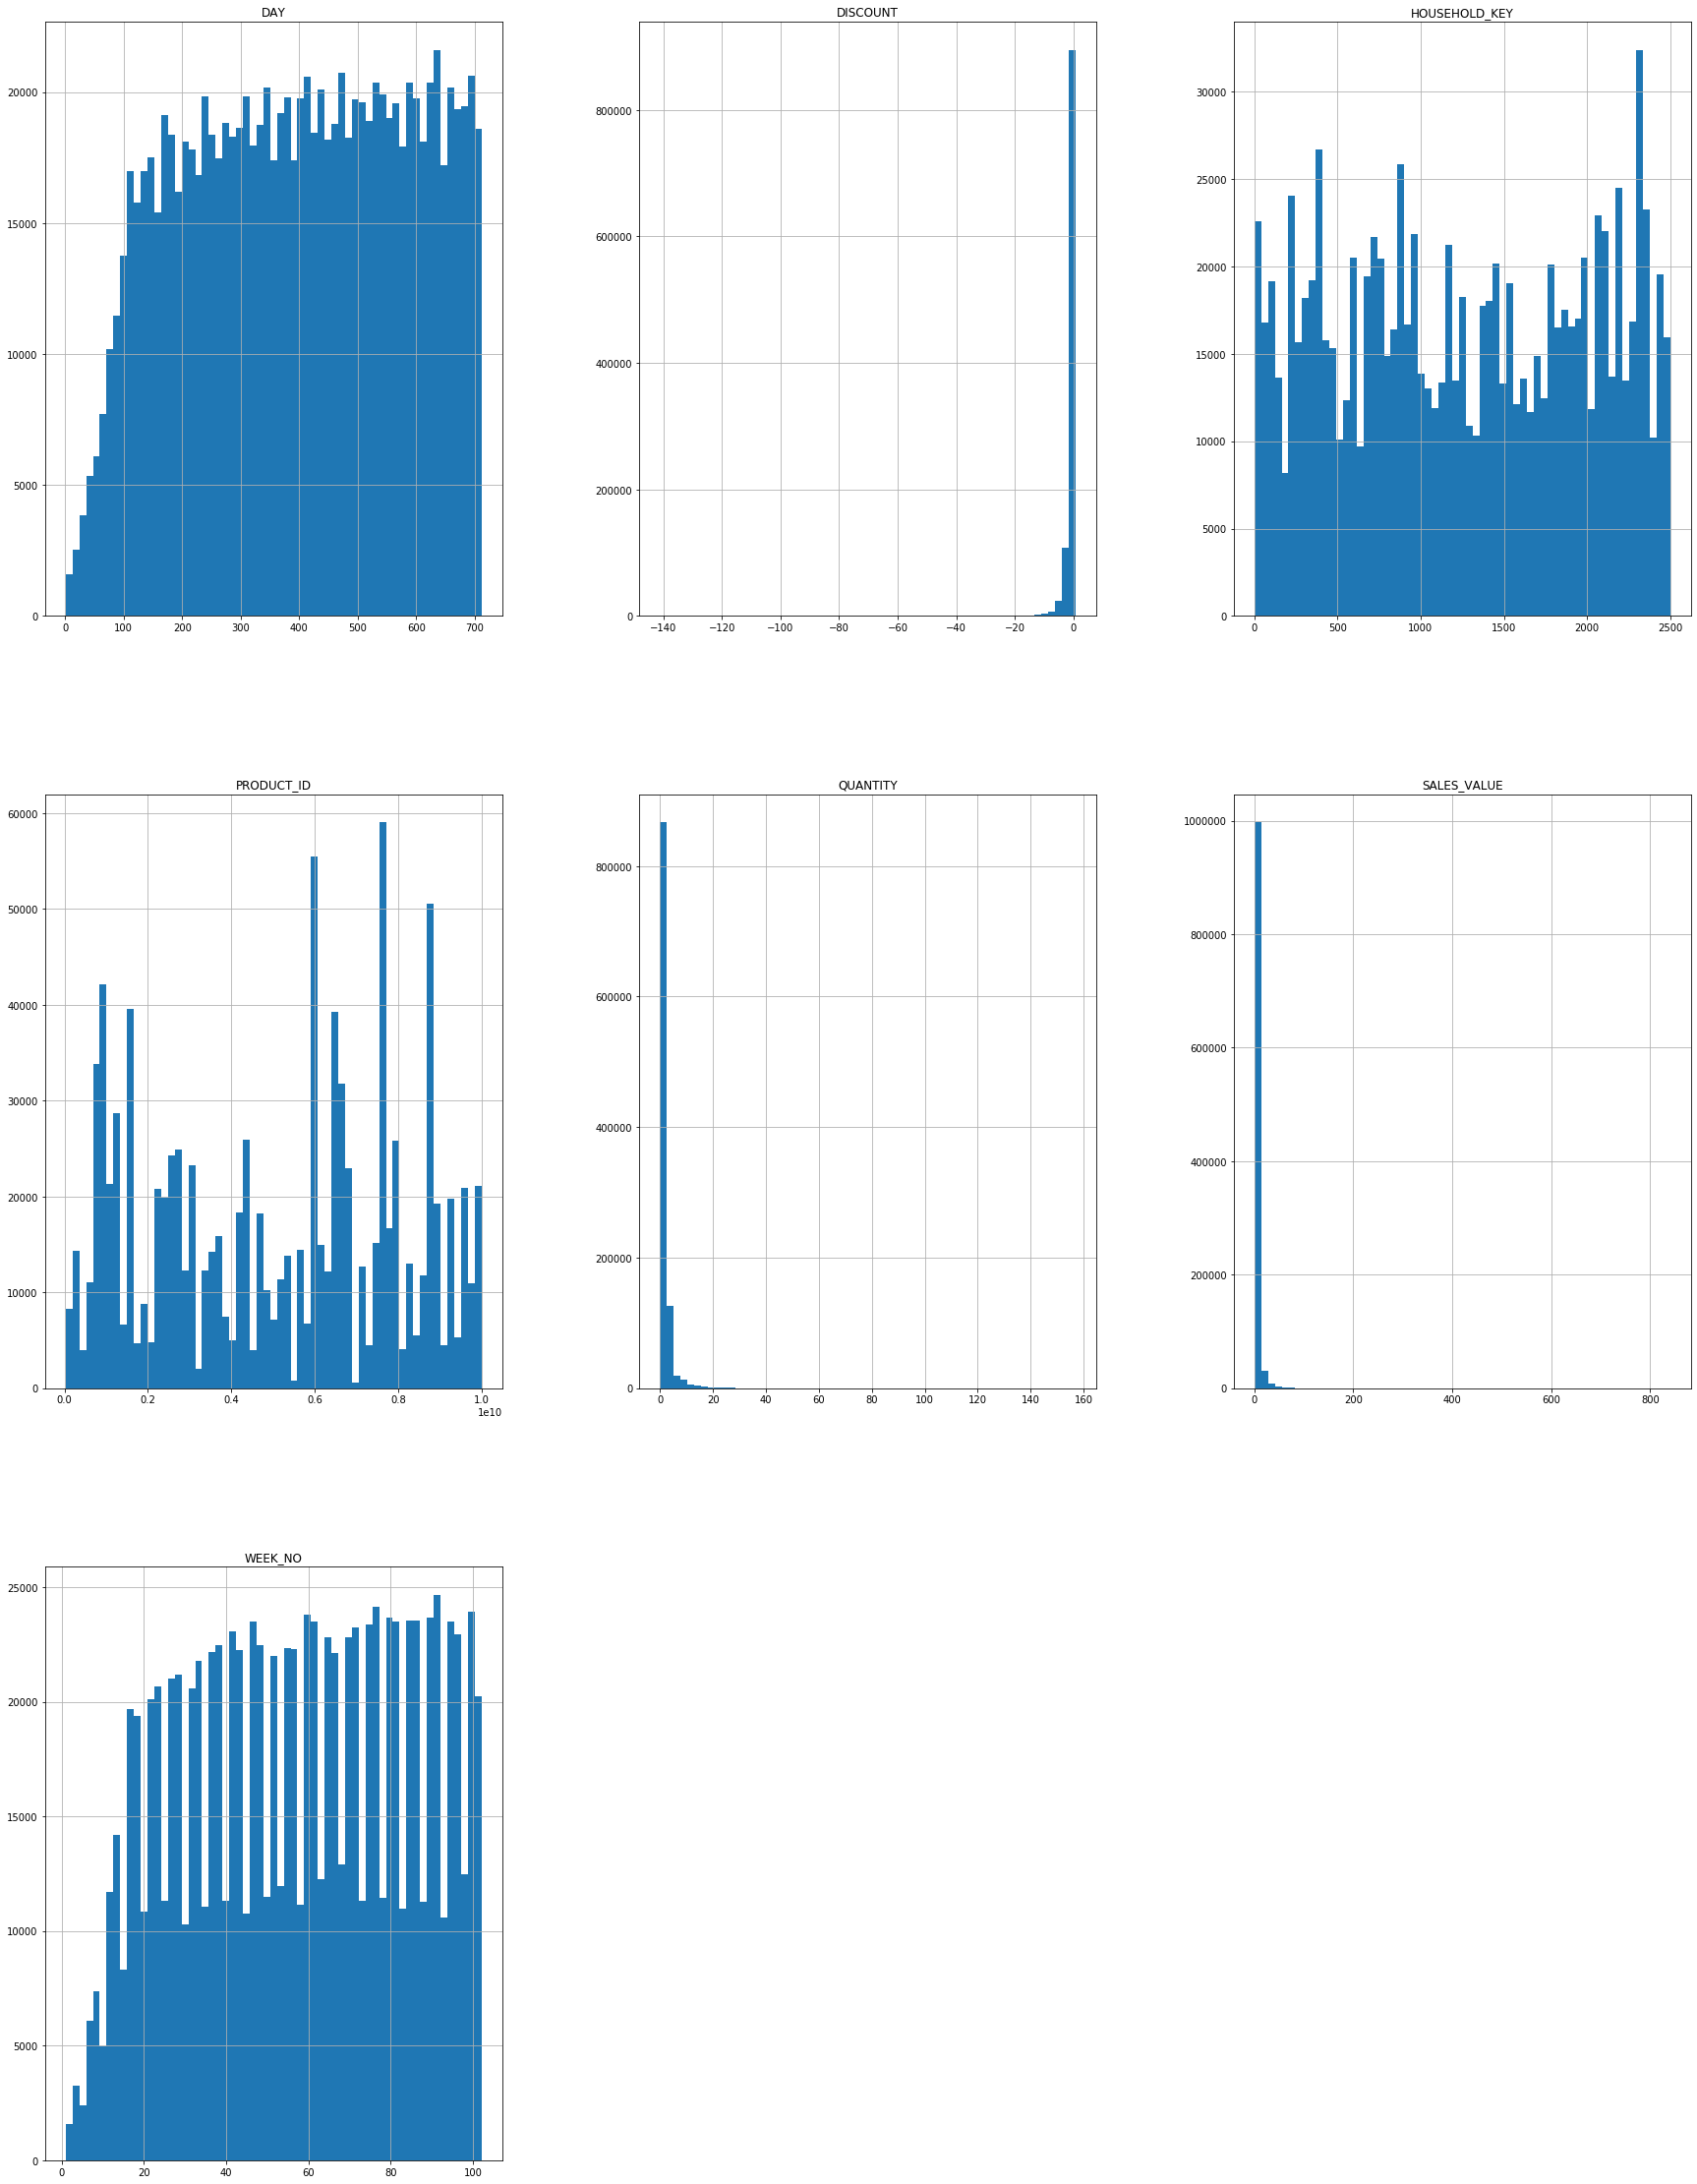

In [8]:
_ = df_transactions.hist(bins=61, figsize=(30,40))

* ### Households are not equally represented. So we need a complete table that we can populate with the information from the dataset


In [9]:

# creating a table that has a row for each week for each household

households = df_transactions['HOUSEHOLD_KEY'].sort_values().unique()
max_week = df_transactions['WEEK_NO'].max()

big_df = pd.DataFrame()

for key in households:
    df = pd.DataFrame()
    df['WEEK_NO'] = np.arange(1,max_week+1)
    df['HOUSEHOLD_KEY'] = key
    
    big_df = pd.concat([big_df,df])

print(big_df.shape)
big_df.head()

(81702, 2)


,WEEK_NO,HOUSEHOLD_KEY
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


* ### "DAY" goes from 1 to 700. Can we get more info on the time of the transaction? E.g. season, month

In [10]:
df_products.head()

,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC
0,3878731104,AUTOMOTIVE,COUPON
1,5617044735,AUTOMOTIVE,NEWSPAPER
2,3333525418,CHARITABLE CONT,UNKNOWN
3,5678132014,CHEF SHOPPE,UNKNOWN
4,6163551664,CNTRL/STORE SUP,COUPON/MISC ITEMS


In [11]:
sorted(df_products['COMMODITY_DESC'].unique())

['(CORP USE ONLY)',
 'ADULT INCONTINENCE',
 'AIR CARE',
 'ANALGESICS',
 'ANTACIDS',
 'APPAREL',
 'APPLES',
 'AUDIO/VIDEO PRODUCTS',
 'AUTOMOTIVE PRODUCTS',
 'BABY FOODS',
 'BABY HBC',
 'BABYFOOD',
 'BACON',
 'BAG SNACKS',
 'BAKED BREAD/BUNS/ROLLS',
 'BAKED SWEET GOODS',
 'BAKERY PARTY TRAYS',
 'BAKING',
 'BAKING MIXES',
 'BAKING NEEDS',
 'BATH',
 'BATH TISSUES',
 'BATTERIES',
 'BEANS - CANNED GLASS & MW',
 'BEEF',
 'BEERS/ALES',
 'BERRIES',
 'BEVERAGE',
 'BIRD SEED',
 'BLEACH',
 'BOOKSTORE',
 'BOTTLE DEPOSITS',
 'BOUQUET (NON ROSE)',
 'BREAD',
 'BREAKFAST SAUSAGE/SANDWICHES',
 'BREAKFAST SWEETS',
 'BROCCOLI/CAULIFLOWER',
 'BROOMS AND MOPS',
 'BULK FOODS',
 'BUTTER',
 'CAKES',
 'CANDLES/ACCESSORIES',
 'CANDY - CHECKLANE',
 'CANDY - PACKAGED',
 'CANNED JUICES',
 'CANNED MILK',
 'CARROTS',
 'CAT FOOD',
 'CAT LITTER',
 'CEREAL/BREAKFAST',
 'CHARCOAL AND LIGHTER FLUID',
 'CHEESE',
 'CHEESES',
 'CHICKEN',
 'CHICKEN/POULTRY',
 'CHIPS&SNACKS',
 'CHRISTMAS  SEASONAL',
 'CIGARETTES',
 'CIGARS',


* ### Aha! 💡There is something called "CHRISTMAS SEASONAL"
Let's search for other seasonal product descriptions

In [12]:
df_products[df_products['COMMODITY_DESC'].str.contains('SEASONAL')]['COMMODITY_DESC'].drop_duplicates()


42          CHRISTMAS  SEASONAL
60     FALL AND WINTER SEASONAL
109      SPRING/SUMMER SEASONAL
326                    SEASONAL
Name: COMMODITY_DESC, dtype: object

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='hist')` instead of `Series.plot('hist',)`.
  if __name__ == '__main__':


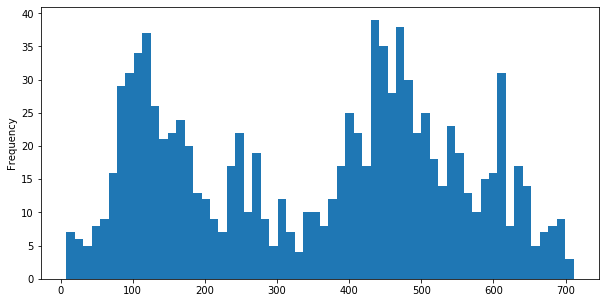

In [13]:
spring_summer_products = df_products[df_products['COMMODITY_DESC']=='SPRING/SUMMER SEASONAL']['PRODUCT_ID'].to_list()
fall_winter_products = df_products[df_products['COMMODITY_DESC']=='FALL AND WINTER SEASONAL']['PRODUCT_ID'].to_list()
christmas_products = df_products[df_products['COMMODITY_DESC'].str.contains('CHRISTMAS')]['PRODUCT_ID'].to_list()

spring_summer = df_transactions[df_transactions['PRODUCT_ID'].isin(spring_summer_products)]
fall_winter = df_transactions[df_transactions['PRODUCT_ID'].isin(fall_winter_products)]
christmas = df_transactions[df_transactions['PRODUCT_ID'].isin(christmas_products)]

spring_summer['DAY'].plot('hist', bins=60, figsize=(10,5))

* ### This gives us a good idea about when spring is and thus we can take a good guess on which month it is.

* ### Additionally, checking when the week number increments, we can find out more about which day of the week a certain transaction takes place.

In [14]:
df_transactions['month'], df_transactions['month_num'] = zip(*df_transactions['DAY'].apply(add_month_names))
df_transactions['weekday'],df_transactions['weekday_num'] = zip(*df_transactions['DAY'].apply(add_week_day_names))
df_transactions['season'] = df_transactions['month'].apply(get_season)
df_transactions.head()

,DAY,WEEK_NO,HOUSEHOLD_KEY,PRODUCT_ID,SALES_VALUE,QUANTITY,DISCOUNT,month,month_num,weekday,weekday_num,season
0,1,1,98,782443249,0.39,1.0,0.00,February,2,Tuesday,2,winter
1,1,1,98,3112548822,3.00,2.0,-0.08,February,2,Tuesday,2,winter
2,1,1,98,6571651611,1.15,4.0,0.00,February,2,Tuesday,2,winter
3,1,1,98,8840487053,1.25,1.0,-0.34,February,2,Tuesday,2,winter
4,1,1,212,782443249,0.65,1.0,0.00,February,2,Tuesday,2,winter


* ### Let's prepare a lookup table where we can find the month and season given a week number

In [15]:
week_month_lookup = df_transactions[['DAY','WEEK_NO','month_num']].drop_duplicates().reset_index().drop('index',axis=1)
week_month_lookup.drop('DAY', axis=1, inplace=True)
week_month_lookup.drop_duplicates(subset=['WEEK_NO'], keep="first", inplace=True)
# note: if a week starts at a month and ends in a different month, we assign it to the month it started in

week_month_season_lookup = week_month_lookup.merge(df_transactions[['WEEK_NO','month_num','month','season']].drop_duplicates(), on=['WEEK_NO','month_num'], how='left')
week_month_season_lookup['year'] = week_month_season_lookup['WEEK_NO'].apply(lambda x: 2018 if x>45 and x<=93 else (2017 if x<=45 else 2019))
print(week_month_season_lookup.shape)
week_month_season_lookup.head(200)


(102, 5)


,WEEK_NO,month_num,month,season,year
0,1,2,February,winter,2017
1,2,2,February,winter,2017
2,3,3,March,spring,2017
3,4,3,March,spring,2017
4,5,3,March,spring,2017
5,6,3,March,spring,2017
6,7,4,April,spring,2017
7,8,4,April,spring,2017
8,9,4,April,spring,2017
9,10,4,April,spring,2017


* ### Let's take a closer look at the product dataset

In [16]:
df_products.head()

,PRODUCT_ID,DEPARTMENT,COMMODITY_DESC
0,3878731104,AUTOMOTIVE,COUPON
1,5617044735,AUTOMOTIVE,NEWSPAPER
2,3333525418,CHARITABLE CONT,UNKNOWN
3,5678132014,CHEF SHOPPE,UNKNOWN
4,6163551664,CNTRL/STORE SUP,COUPON/MISC ITEMS


* ### Maybe we can find commonly bought products and visited departments

In [17]:
# Tables that shows us the most popular departments and products
# how many times a family bought from them, normalised

things_families_buy = df_transactions[['HOUSEHOLD_KEY','PRODUCT_ID']].merge(df_products, on='PRODUCT_ID', how='left')
things_families_buy = things_families_buy[['HOUSEHOLD_KEY','DEPARTMENT','COMMODITY_DESC']]
things_families_buy.sort_values(by='HOUSEHOLD_KEY').head()

# finding most popular department
most_popular_department = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_department = most_popular_department.groupby('DEPARTMENT').size().reset_index()
most_popular_department.rename(columns={0:'count'}, inplace=True)
most_popular_department = most_popular_department.sort_values('count', ascending=False)
most_popular_department_list = most_popular_department.head()['DEPARTMENT'].tolist()
most_popular_department_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','DEPARTMENT']).size().reset_index()
most_popular_department_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_department_per_family_reduced = most_popular_department_per_family[most_popular_department_per_family['DEPARTMENT'].isin(most_popular_department_list)]
popular_department_table = most_popular_department_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'DEPARTMENT', values='count')
popular_department_table.columns.name = None
popular_department_table.fillna(0, inplace=True)
popular_department_table = popular_department_table.reset_index()

x = popular_department_table.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
values = pd.DataFrame(x_scaled)
values.columns = popular_department_table.columns
values['HOUSEHOLD_KEY'] = popular_department_table['HOUSEHOLD_KEY']
popular_department_table = values.copy()

# finding most popular products
most_popular_commodity = things_families_buy.drop('HOUSEHOLD_KEY', axis=1).reset_index().drop('index',axis=1)
most_popular_commodity = most_popular_commodity.groupby('COMMODITY_DESC').size().reset_index()
most_popular_commodity.rename(columns={0:'count'}, inplace=True)
most_popular_commodity = most_popular_commodity.sort_values('count', ascending=False)
most_popular_commodity_list = most_popular_commodity.head()['COMMODITY_DESC'].tolist()
most_popular_commodity_per_family = things_families_buy.groupby(['HOUSEHOLD_KEY','COMMODITY_DESC']).size().reset_index()
most_popular_commodity_per_family.rename(columns={0:'count'}, inplace=True)
most_popular_commodity_per_family_reduced = most_popular_commodity_per_family[most_popular_commodity_per_family['COMMODITY_DESC'].isin(most_popular_commodity_list)]
popular_commodity_table = most_popular_commodity_per_family_reduced.pivot(index='HOUSEHOLD_KEY', columns = 'COMMODITY_DESC', values='count')
popular_commodity_table.columns.name = None
popular_commodity_table.fillna(0, inplace=True)
popular_commodity_table = popular_commodity_table.reset_index()

x = popular_commodity_table.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
values = pd.DataFrame(x_scaled)
values.columns = popular_commodity_table.columns
values['HOUSEHOLD_KEY'] = popular_commodity_table['HOUSEHOLD_KEY']
popular_commodity_table = values.copy()

print(popular_department_table.head())
popular_commodity_table.head()


   HOUSEHOLD_KEY   DRUG GM   GROCERY      MEAT  MEAT-PCKGD   PRODUCE
0              1  0.141615  0.270451  0.016949    0.352713  0.147233
1              7  0.135404  0.169252  0.148305    0.089147  0.112648
2              8  0.176398  0.266220  0.220339    0.248062  0.142292
3             13  0.352795  0.342031  0.004237    0.286822  0.104743
4             16  0.031056  0.075458  0.063559    0.065891  0.038538


,HOUSEHOLD_KEY,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS
0,1,0.231183,0.322751,0.253333,0.229885,0.090062
1,7,0.096774,0.142857,0.153333,0.132184,0.037267
2,8,0.096774,0.232804,0.280000,0.241379,0.090062
3,13,0.166667,0.185185,0.286667,0.586207,0.102484
4,16,0.053763,0.359788,0.033333,0.258621,0.015528


# 4. Fitting a preliminary model <a class="anchor" id="train_first"></a>
[Back to top](#menu)

* ### Before fitting a model, we need to aggregate the data to represent weekly behaviour

In [18]:
transactions_weekly_aggregated = df_transactions.groupby(["HOUSEHOLD_KEY", "WEEK_NO"])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
transactions_weekly_aggregated = transactions_weekly_aggregated.sort_values(by=['HOUSEHOLD_KEY','WEEK_NO']).reset_index().drop('index', axis=1)
start_df = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
start_df = start_df.fillna(0)
print(start_df.shape)
start_df.head()


(81702, 5)


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT
0,1,1,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0


* ### Bring in the time information and the popular products & department information

In [19]:
# Merge everything together

a = start_df.merge(week_month_season_lookup, on='WEEK_NO', how='left')
b = a.merge(popular_department_table, on='HOUSEHOLD_KEY', how='left')
c = b.merge(popular_commodity_table, on='HOUSEHOLD_KEY', how='left')

d = c.merge(df_demographics, on='HOUSEHOLD_KEY', how='left')
e = d.merge(df_campaigns, on='WEEK_NO', how='left')
f = e.merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

all_data = f.copy()
all_data.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS
0,1,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN


* ### Separate the training and test data

In [20]:
# select columns for training
exclude_columns = ['WEEK_NO','HOUSEHOLD_KEY']
training_columns = [x for x in all_data.columns if x not in exclude_columns]
columns_to_predict_on = [x for x in training_columns if x != 'SALES_VALUE']

training_data = all_data[training_columns]
training_data.dropna(inplace=True)

# divide data into training and test set
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print('Amount of all data: ' +str(X.shape[0]))

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

print('Amount of training data: ' + str(X_train.shape[0]))
print('Amount of test data: ' + str(X_test.shape[0]))

Amount of all data: 34378
Amount of training data: 27502
Amount of test data: 6876


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


* ### Let's train our model

In [21]:
param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:34.7721	train-rmse:33.214
[1]	eval-rmse:15.9622	train-rmse:15.6559
[2]	eval-rmse:13.6483	train-rmse:11.4828
[3]	eval-rmse:14.2619	train-rmse:10.1816
[4]	eval-rmse:15.2869	train-rmse:9.69522
[5]	eval-rmse:15.3444	train-rmse:9.46209
[6]	eval-rmse:16.4196	train-rmse:9.15357
[7]	eval-rmse:17.1893	train-rmse:8.89563
[8]	eval-rmse:17.9858	train-rmse:8.83361
[9]	eval-rmse:17.5278	train-rmse:8.75637
[10]	eval-rmse:17.2942	train-rmse:8.7055
[11]	eval-rmse:17.4947	train-rmse:8.6331
[12]	eval-rmse:17.3644	train-rmse:8.54695
[13]	eval-rmse:16.9689	train-rmse:8.18401
[14]	eval-rmse:16.7208	train-rmse:8.15503


* ### Evaluation metrics

In [22]:
preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
r2 = r2_score(y_test, preds) 

print('mean absolute error: ' + str(mae))
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))
print('R2: ' + str(r2))

mean absolute error: 6.4621177792460704
mean squared error: 279.5854617872055
root mean squared error: 16.72080924438783
mean absolute percentage error: 16.72080924438783
R2: 0.9521730476334248


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in true_divide


### Looks pretty good! Let's see which feature helps us predict the sales amount this well.

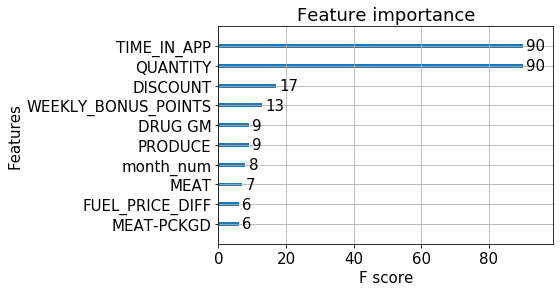

In [23]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

### Oops. We might have made a mistake! 😅

In [24]:
# fix leakage problem
all_data_after_leakage = all_data.copy()

#1
all_data_after_leakage['QUANTITY'] = all_data_after_leakage.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)

#2
all_data_after_leakage['DISCOUNT'] = all_data_after_leakage.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)

#3
all_data_after_leakage['TIME_IN_APP'] = all_data_after_leakage.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)


training_data = all_data_after_leakage[training_columns]
training_data.dropna(inplace=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


* ### Let's try it again

In [25]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

param = {'max_depth':5, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 15
bst = xgb.train(param, dtrain, num_round, evallist)


/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


(34835, 41)
[0]	eval-rmse:67.4395	train-rmse:61.9481
[1]	eval-rmse:62.972	train-rmse:54.5765
[2]	eval-rmse:62.5623	train-rmse:52.7735
[3]	eval-rmse:62.3726	train-rmse:51.8006
[4]	eval-rmse:62.2955	train-rmse:51.2986
[5]	eval-rmse:62.088	train-rmse:50.8977
[6]	eval-rmse:62.4013	train-rmse:50.4294
[7]	eval-rmse:62.4691	train-rmse:50.0775
[8]	eval-rmse:62.1683	train-rmse:49.3412
[9]	eval-rmse:62.2212	train-rmse:49.0805
[10]	eval-rmse:61.9449	train-rmse:48.891
[11]	eval-rmse:62.0234	train-rmse:48.6277
[12]	eval-rmse:62.2314	train-rmse:48.1623
[13]	eval-rmse:62.9188	train-rmse:47.9964
[14]	eval-rmse:63.2312	train-rmse:47.6327


In [26]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))

mean absolute error: 44.68606082501569
mean squared error: 3998.1879280687776
root mean squared error: 63.23122589408478
mean absolute percentage error: 63.23122589408478
R2: 0.3124013242345456


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


* ### We have a model to improve!

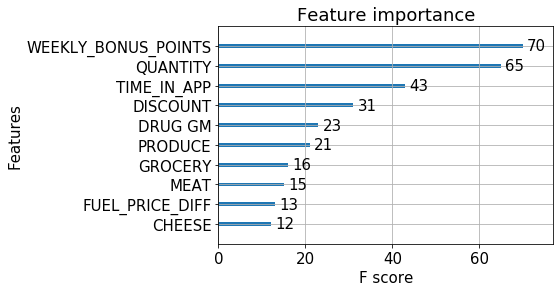

In [27]:
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)

# 5. Feature Engineering <a class="anchor" id="feature_engineering"></a>
[jump to end of this part](#bring_together)
[Back to top](#menu)

### 5.1. days since last shopping for every week

In [28]:
daily_transactions = df_transactions.groupby(["HOUSEHOLD_KEY", "DAY",'WEEK_NO'])[["SALES_VALUE",'QUANTITY','DISCOUNT']].sum().reset_index()
daily_transactions['last_shopping_day'] = daily_transactions.groupby('HOUSEHOLD_KEY')['DAY'].shift(1)
daily_transactions['days_since_shopping'] = daily_transactions['DAY']-daily_transactions['last_shopping_day']
daily_transactions = daily_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO','days_since_shopping']]

previous_visit_day = daily_transactions.groupby(['HOUSEHOLD_KEY','WEEK_NO']).mean().reset_index()
previous_visit_day.drop('DAY', axis=1, inplace=True)

a = big_df.merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
a['days_since_last_shopping'] = a.groupby('HOUSEHOLD_KEY')['days_since_shopping'].apply(fill_nas_for_last_day)

previous_visit_day = a[['HOUSEHOLD_KEY', 'WEEK_NO', 'days_since_last_shopping']].copy()
print(previous_visit_day.shape)
previous_visit_day.head(10)


(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,days_since_last_shopping
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,NaN
4,1,5,NaN
5,1,6,NaN
6,1,7,NaN
7,1,8,2.0
8,1,9,9.0
9,1,10,16.0


### 5.2. Amount spent on last shopping trip

In [29]:
spent_last_trip_df = transactions_weekly_aggregated.copy()
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['SALES_VALUE']#.shift(1)
spent_last_trip_df = big_df.merge(spent_last_trip_df[['HOUSEHOLD_KEY','WEEK_NO','amount_spent_last_trip']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df.groupby('HOUSEHOLD_KEY')['amount_spent_last_trip'].apply(fill_nas_for_spent_trip)
spent_last_trip_df['amount_spent_last_trip'] = spent_last_trip_df['amount_spent_last_trip'].shift(1)
spent_last_trip_df.head(10)


,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_trip
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,78.66
9,10,1,78.66


### 5.3. Amount spent last week

In [30]:
spent_last_week_df = transactions_weekly_aggregated.copy()
spent_last_week_df = big_df.merge(spent_last_week_df[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
spent_last_week_df['amount_spent_last_week'] = spent_last_week_df['SALES_VALUE'].shift(1)
spent_last_week_df['amount_spent_last_week'].fillna(0, inplace=True)
spent_last_week_df = spent_last_week_df[['WEEK_NO','HOUSEHOLD_KEY','amount_spent_last_week']]
spent_last_week_df.head(10)

,WEEK_NO,HOUSEHOLD_KEY,amount_spent_last_week
0,1,1,0.00
1,2,1,0.00
2,3,1,0.00
3,4,1,0.00
4,5,1,0.00
5,6,1,0.00
6,7,1,0.00
7,8,1,0.00
8,9,1,78.66
9,10,1,0.00


### 5.4. Number of weeks since last shopping

In [31]:
num_weeks_since_last_visit = transactions_weekly_aggregated.copy()
num_weeks_since_last_visit['last_shopping_week'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['WEEK_NO'].shift(1)
num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit['WEEK_NO']-num_weeks_since_last_visit['last_shopping_week']

num_weeks_since_last_visit = num_weeks_since_last_visit[['HOUSEHOLD_KEY','WEEK_NO','weeks_since_last_shopping']]

num_weeks_since_last_visit = big_df.merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

num_weeks_since_last_visit['weeks_since_last_shopping'] = num_weeks_since_last_visit.groupby('HOUSEHOLD_KEY')['weeks_since_last_shopping'].apply(fill_nas_for_last_week)

num_weeks_since_last_visit.head(10)

,WEEK_NO,HOUSEHOLD_KEY,weeks_since_last_shopping
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,0.0
8,9,1,1.0
9,10,1,2.0


### 5.5. average spent on previous shopping trips (with stats)

In [32]:
# calculate stats 
transactions_with_time = transactions_weekly_aggregated.copy()

mean = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean = mean.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean = mean.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean.index = mean['level_1']

mean = mean.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean = mean.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean['avg_spending_previous_trips'] = mean.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean = mean.drop('SALES_VALUE', axis=1)
# print(mean.shape)
# mean.head(100)

std = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std = std.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std = std.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std.index = std['level_1']

std = std.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std = std.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std['std_spending_previous_trips'] = std.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std = std.drop('SALES_VALUE', axis=1)
# print(std.shape)
# std.head(100)

var = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var = var.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var = var.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var.index = var['level_1']

var = var.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var = var.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var['var_spending_previous_trips'] = var.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var = var.drop('SALES_VALUE', axis=1)
# print(var.shape)
# var.head(100)

quan25 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25 = quan25.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25 = quan25.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25.index = quan25['level_1']

quan25 = quan25.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25 = quan25.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25['quan25_spending_previous_trips'] = quan25.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25 = quan25.drop('SALES_VALUE', axis=1)
# print(quan25.shape)
# quan25.head(100)

quan50 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50 = quan50.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50 = quan50.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50.index = quan50['level_1']

quan50 = quan50.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50 = quan50.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50['quan50_spending_previous_trips'] = quan50.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50 = quan50.drop('SALES_VALUE', axis=1)
# print(quan50.shape)
# quan50.head(100)

quan75 = transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75 = quan75.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75 = quan75.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75.index = quan75['level_1']

quan75 = quan75.join(transactions_with_time[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75 = quan75.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75['quan75_spending_previous_trips'] = quan75.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75 = quan75.drop('SALES_VALUE', axis=1)
# print(quan75.shape)
# quan75.head(100)

stats_prev_trips = big_df.merge(mean, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(std, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(var, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan25, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan50, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_trips = stats_prev_trips.merge(quan75, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

for column in stats_prev_trips:
    if column != 'WEEK_NO' or column != 'HOUSEHOLD_KEY':
        stats_prev_trips[column] = stats_prev_trips.groupby('HOUSEHOLD_KEY')[column].apply(fill_nas_for_prev_trip)

stats_prev_trips.head()


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN


### 5.6. average spent on previous weeks (with stats)

In [33]:
# calculate stats 
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

mean_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
mean_r = mean_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().mean()
mean_r = mean_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
mean_r.index = mean_r['level_1']

mean_r = mean_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
mean_r = mean_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
mean_r['avg_spending_previous_weeks_real_time'] = mean_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
mean_r = mean_r.drop('SALES_VALUE', axis=1)
# print(mean_r.shape)
# mean_r.head(10)


std_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
std_r = std_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().std()
std_r = std_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
std_r.index = std_r['level_1']

std_r = std_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
std_r = std_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
std_r['std_spending_previous_weeks_real_time'] = std_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
std_r = std_r.drop('SALES_VALUE', axis=1)
# print(std_r.shape)
# std_r.head()


var_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
var_r = var_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().var()
var_r = var_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
var_r.index = var_r['level_1']

var_r = var_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
var_r = var_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
var_r['var_spending_previous_weeks_real_time'] = var_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
var_r = var_r.drop('SALES_VALUE', axis=1)
# print(var_r.shape)
# var_r.head(10)


quan25_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan25_r = quan25_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.25)
quan25_r = quan25_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan25_r.index = quan25_r['level_1']

quan25_r = quan25_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan25_r = quan25_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan25_r['quan25_spending_previous_weeks_real_time'] = quan25_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan25_r = quan25_r.drop('SALES_VALUE', axis=1)
# print(quan25_r.shape)
# quan25_r.head(10)


quan50_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan50_r = quan50_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.5)
quan50_r = quan50_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan50_r.index = quan50_r['level_1']

quan50_r = quan50_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan50_r = quan50_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan50_r['quan50_spending_previous_weeks_real_time'] = quan50_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan50_r = quan50_r.drop('SALES_VALUE', axis=1)
# print(quan50_r.shape)
# quan50_r.head(10)


quan75_r = transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO','SALES_VALUE']]
quan75_r = quan75_r.sort_values(by='WEEK_NO').groupby('HOUSEHOLD_KEY').expanding().quantile(0.75)
quan75_r = quan75_r.drop('HOUSEHOLD_KEY', axis=1).reset_index()
quan75_r.index = quan75_r['level_1']

quan75_r = quan75_r.join(transactions_every_week[['HOUSEHOLD_KEY','WEEK_NO']], lsuffix='_avg')
quan75_r = quan75_r.drop(['HOUSEHOLD_KEY_avg','level_1','WEEK_NO_avg'], axis=1).reset_index().drop('level_1', axis=1)
quan75_r['quan75_spending_previous_weeks_real_time'] = quan75_r.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
quan75_r = quan75_r.drop('SALES_VALUE', axis=1)
# print(quan75_r.shape)
# quan75_r.head(10)

stats_prev_weeks = big_df.merge(mean_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(std_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(var_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan25_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan50_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')
stats_prev_weeks = stats_prev_weeks.merge(quan75_r, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(stats_prev_weeks.shape)
stats_prev_weeks.head(10)


(81702, 8)


,WEEK_NO,HOUSEHOLD_KEY,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time
0,1,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,NaN,NaN,NaN,NaN,NaN,NaN
5,6,1,NaN,NaN,NaN,NaN,NaN,NaN
6,7,1,NaN,NaN,NaN,NaN,NaN,NaN
7,8,1,NaN,NaN,NaN,NaN,NaN,NaN
8,9,1,78.66,NaN,NaN,78.66,78.66,78.66
9,10,1,78.66,NaN,NaN,78.66,78.66,78.66


### 5.7. weighted mean of last 10 trips' spendings

In [34]:
weighted_avg_trips = transactions_weekly_aggregated.copy()
weighted_avg_trips['1_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
weighted_avg_trips['2_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(2)
weighted_avg_trips['3_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(3)
weighted_avg_trips['4_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(4)
weighted_avg_trips['5_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(5)
weighted_avg_trips['6_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(6)
weighted_avg_trips['7_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(7)
weighted_avg_trips['8_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(8)
weighted_avg_trips['9_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(9)
weighted_avg_trips['10_times_before'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(10)

weighted_avg_trips['weighted_avg_trips'] = (weighted_avg_trips['1_times_before']*10 + 
                               weighted_avg_trips['2_times_before']*9 +
                               weighted_avg_trips['3_times_before']*8 +
                               weighted_avg_trips['4_times_before']*7 +
                               weighted_avg_trips['5_times_before']*6 +
                               weighted_avg_trips['6_times_before']*5 +
                               weighted_avg_trips['7_times_before']*4 +
                               weighted_avg_trips['8_times_before']*3 +
                               weighted_avg_trips['9_times_before']*2 +
                               weighted_avg_trips['10_times_before']*1)/(1+2+3+4+5+6+7+8+9+10)

weighted_avg_trips = weighted_avg_trips[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg_trips']]

weighted_avg_trips = big_df.merge(weighted_avg_trips[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg_trips']], on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

weighted_avg_trips['weighted_avg_trips'] = weighted_avg_trips.groupby('HOUSEHOLD_KEY')['weighted_avg_trips'].apply(fill_nas_for_weighted_avg)
weighted_avg_trips.head(10)




,WEEK_NO,HOUSEHOLD_KEY,weighted_avg_trips
0,1,1,NaN
1,2,1,NaN
2,3,1,NaN
3,4,1,NaN
4,5,1,NaN
5,6,1,NaN
6,7,1,NaN
7,8,1,NaN
8,9,1,NaN
9,10,1,NaN


### 5.8. weighted mean of last 10 weeks' spendings

In [35]:
transactions_every_week = big_df.merge(transactions_weekly_aggregated, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

weighted_avg_weeks = transactions_every_week.copy()
weighted_avg_weeks['1_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(1)
weighted_avg_weeks['2_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(2)
weighted_avg_weeks['3_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(3)
weighted_avg_weeks['4_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(4)
weighted_avg_weeks['5_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(5)
weighted_avg_weeks['6_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(6)
weighted_avg_weeks['7_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(7)
weighted_avg_weeks['8_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(8)
weighted_avg_weeks['9_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(9)
weighted_avg_weeks['10_times_before'] = weighted_avg_weeks.groupby('HOUSEHOLD_KEY')['SALES_VALUE'].shift(10)

weighted_avg_weeks['weighted_avg_weeks'] = (weighted_avg_weeks['1_times_before']*10 + 
                               weighted_avg_weeks['2_times_before']*9 +
                               weighted_avg_weeks['3_times_before']*8 +
                               weighted_avg_weeks['4_times_before']*7 +
                               weighted_avg_weeks['5_times_before']*6 +
                               weighted_avg_weeks['6_times_before']*5 +
                               weighted_avg_weeks['7_times_before']*4 +
                               weighted_avg_weeks['8_times_before']*3 +
                               weighted_avg_weeks['9_times_before']*2 +
                               weighted_avg_weeks['9_times_before']*1)/(1+2+3+4+5+6+7+8+9+10)

weighted_avg_weeks = weighted_avg_weeks[['HOUSEHOLD_KEY','WEEK_NO','weighted_avg_weeks']]
weighted_avg_weeks.head(10)


,HOUSEHOLD_KEY,WEEK_NO,weighted_avg_weeks
0,1,1,NaN
1,1,2,NaN
2,1,3,NaN
3,1,4,NaN
4,1,5,NaN
5,1,6,NaN
6,1,7,NaN
7,1,8,NaN
8,1,9,NaN
9,1,10,NaN


### 5.9. average visits per week

In [36]:
family_weekly_visits = df_transactions[['HOUSEHOLD_KEY','DAY','WEEK_NO']].drop_duplicates()
family_weekly_visits = family_weekly_visits.groupby(['HOUSEHOLD_KEY','WEEK_NO']).size().reset_index()
family_weekly_visits.rename(columns={0:'week_visit_count'}, inplace=True)
week_visit_count = family_weekly_visits.copy()

expanded_weekly_visit_count = big_df.merge(week_visit_count, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').fillna(0)

rolling_avg_weekly_visit = expanded_weekly_visit_count.sort_values('WEEK_NO').copy()

rolling_avg_weekly_visit = pd.DataFrame(rolling_avg_weekly_visit.groupby('HOUSEHOLD_KEY')['week_visit_count'].expanding().mean())
rolling_avg_weekly_visit = rolling_avg_weekly_visit.reset_index()
rolling_avg_weekly_visit.drop('level_1', axis=1, inplace=True)

week_col = [[i for i in range(1,103)]]*801
week_col = [i for sublist in week_col for i in sublist]
print(len(week_col))

rolling_avg_weekly_visit['WEEK_NO'] = week_col

average_from_past_weeks = rolling_avg_weekly_visit.copy()

average_from_past_weeks['avg_visits_per_week'] = average_from_past_weeks.groupby('HOUSEHOLD_KEY')['week_visit_count'].shift(1)
average_from_past_weeks.drop('week_visit_count', axis=1, inplace=True)

print(average_from_past_weeks.shape)
average_from_past_weeks.head()


81702
(81702, 3)


,HOUSEHOLD_KEY,WEEK_NO,avg_visits_per_week
0,1,1,NaN
1,1,2,0.0
2,1,3,0.0
3,1,4,0.0
4,1,5,0.0


### 5.10. average visits per month

In [37]:
weekly_visit_count = rolling_avg_weekly_visit.copy()
weekly_visit_count['year'] = weekly_visit_count['WEEK_NO'].apply(lambda x: 2018 if x>45 and x<=93 else (2017 if x<=45 else 2019))

weekly_visit_count = weekly_visit_count.merge(week_month_lookup, on=['WEEK_NO'], how='left')

monthly_visit_count = weekly_visit_count.drop('WEEK_NO', axis=1)
monthly_visit_count = pd.DataFrame(monthly_visit_count.groupby(['HOUSEHOLD_KEY','month_num','year'])['week_visit_count'].sum())
monthly_visit_count = monthly_visit_count.reset_index()
monthly_visit_count.rename(columns={'week_visit_count':'month_visit_count'}, inplace=True)
monthly_visit_count = monthly_visit_count.sort_values(['HOUSEHOLD_KEY','year','month_num'], ascending=True).reset_index().drop('index', axis=1)
month_year_table = monthly_visit_count[['year','month_num']]

rolling_avg_monthly_visits = monthly_visit_count.copy()
rolling_avg_monthly_visits = pd.DataFrame(rolling_avg_monthly_visits.groupby('HOUSEHOLD_KEY')['month_visit_count'].expanding().mean())
rolling_avg_monthly_visits = rolling_avg_monthly_visits.reset_index()
rolling_avg_monthly_visits.drop('level_1', axis=1, inplace=True)
rolling_avg_monthly_visits = rolling_avg_monthly_visits.join(month_year_table)

average_from_past_months = rolling_avg_monthly_visits.copy()
average_from_past_months['avg_visits_per_month'] = average_from_past_months.groupby('HOUSEHOLD_KEY')['month_visit_count'].shift(1)
average_from_past_months.drop('month_visit_count', axis=1, inplace=True)

print(average_from_past_months.shape)
average_from_past_months.head()


(20826, 4)


,HOUSEHOLD_KEY,year,month_num,avg_visits_per_month
0,1,2017,2,NaN
1,1,2017,3,0.000000
2,1,2017,4,0.000000
3,1,2017,5,0.205976
4,1,2017,6,0.408603


### 5.11. proportion of shopping weekdays and time of day

In [38]:
all_hhs = df_transactions['HOUSEHOLD_KEY'].sort_values().drop_duplicates().tolist()
household_column = [[hh]*7*102 for hh in all_hhs]
household_column = [h for sub in household_column for h in sub]

week_col = [[[i]*7 for i in range(1,103)]]*801
week_col = [i for sublist in week_col for i in sublist]
week_col = [i for sublist in week_col for i in sublist]
weekday_column = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']*102*801
all_weeks_households_weekdays = pd.DataFrame(list(zip(household_column,week_col,weekday_column)), columns=['HOUSEHOLD_KEY','WEEK_NO','weekday'])

shopping_days = df_transactions[['HOUSEHOLD_KEY','WEEK_NO','weekday']].drop_duplicates()

shopping_days = shopping_days.sort_values(['HOUSEHOLD_KEY','WEEK_NO'])
shopping_days['exists'] = 1

all_weeks_households_weekdays_count = all_weeks_households_weekdays.merge(shopping_days, on=['HOUSEHOLD_KEY','WEEK_NO','weekday'], how='left')
all_weeks_households_weekdays_count.fillna(0, inplace=True)

print(all_weeks_households_weekdays_count.shape)
all_weeks_households_weekdays_count.head()

grouped_shopping_day_proportions = all_weeks_households_weekdays_count.groupby('HOUSEHOLD_KEY')

new_df = pd.DataFrame()
for name, group in grouped_shopping_day_proportions:
#     print(group)
    hh_key = group['HOUSEHOLD_KEY'].iloc[0]
    
    weekdays = group[['WEEK_NO','weekday','exists']]
    
    week_col = [[i for i in range(1,103)]]*7
    week_col = [i for sublist in week_col for i in sublist]
    
    hh_col = [[hh_key]*102*7]
    hh_col = [h for sub in hh_col for h in sub]
    
    weekdays = weekdays.groupby('weekday').expanding().sum().reset_index()
    
    weekdays['WEEK_NO'] = week_col
    weekdays['HOUSEHOLD_KEY'] = hh_col
    weekdays.drop('level_1', axis=1, inplace=True)
    
    new_df = new_df.append(weekdays)   
    
    
shopping_day_proportions = new_df.copy()

visit_day_counts = pd.pivot_table(shopping_day_proportions, columns = 'weekday', values='exists', index=['HOUSEHOLD_KEY','WEEK_NO'] )

visit_day_proportions = visit_day_counts.copy()
visit_day_proportions['total_visits'] =  visit_day_proportions[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].sum(axis=1)
visit_day_proportions = visit_day_proportions[['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']].div(visit_day_proportions['total_visits'], axis=0)
visit_day_proportions.columns = [str(col) + ' %' for col in visit_day_proportions.columns]
visit_day_proportions = visit_day_proportions.reset_index()
visit_day_proportions.fillna(0, inplace=True)

print(visit_day_proportions.shape)
visit_day_proportions.head(10)


(571914, 4)
(81702, 9)


,HOUSEHOLD_KEY,WEEK_NO,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1,8,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,1,9,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,1,10,0.0,0.0,0.5,0.0,0.5,0.0,0.0


# 6. Bring everything together <a class="anchor" id="bring_together"></a>
[Back to top](#menu)

In [44]:
all_data = start_df.merge(week_month_season_lookup, on='WEEK_NO', how='left').merge(popular_department_table, on='HOUSEHOLD_KEY', how='left').merge(popular_commodity_table, on='HOUSEHOLD_KEY', how='left').merge(df_demographics, on='HOUSEHOLD_KEY', how='left').merge(df_campaigns, on='WEEK_NO', how='left').merge(df_promotions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(previous_visit_day, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(spent_last_trip_df, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(spent_last_week_df, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(num_weeks_since_last_visit, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(stats_prev_trips, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(stats_prev_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(weighted_avg_trips, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(weighted_avg_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(average_from_past_weeks, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left').merge(average_from_past_months, on=['HOUSEHOLD_KEY','month_num','year'], how='left').merge(visit_day_proportions, on=['HOUSEHOLD_KEY','WEEK_NO'], how='left')

print(all_data.shape)
all_data.head()

(81702, 57)


,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_trips,weighted_avg_weeks,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* ### Again, we need to move the information to reflect previous week's data

In [45]:
# fix leakage problem
all_data_leak_proof = all_data.copy()
all_data_leak_proof['QUANTITY'] = all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['QUANTITY'].shift(1)
all_data_leak_proof['DISCOUNT'] = all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['DISCOUNT'].shift(1)
all_data_leak_proof['TIME_IN_APP'] =  all_data_leak_proof.sort_values('WEEK_NO').groupby('HOUSEHOLD_KEY')['TIME_IN_APP'].shift(1)


In [47]:
all_data_leak_proof.head()

,WEEK_NO,HOUSEHOLD_KEY,SALES_VALUE,QUANTITY,DISCOUNT,month_num,month,season,year,DRUG GM,GROCERY,MEAT,MEAT-PCKGD,PRODUCE,BAG SNACKS,BAKED BREAD/BUNS/ROLLS,CHEESE,FLUID MILK PRODUCTS,SOFT DRINKS,AGE_MEAN,HOUSEHOLD_SIZE,NUM_ADULTS,NUM_CHILDREN,MARITAL_STATUS,INCOME_MEAN,NUM_CAMPAIGNS,FUEL_PRICE_DIFF,NUM_COUPONS,TIME_IN_APP,WEEKLY_BONUS_POINTS,days_since_last_shopping,amount_spent_last_trip,amount_spent_last_week,weeks_since_last_shopping,avg_spending_previous_trips,std_spending_previous_trips,var_spending_previous_trips,quan25_spending_previous_trips,quan50_spending_previous_trips,quan75_spending_previous_trips,avg_spending_previous_weeks_real_time,std_spending_previous_weeks_real_time,var_spending_previous_weeks_real_time,quan25_spending_previous_weeks_real_time,quan50_spending_previous_weeks_real_time,quan75_spending_previous_weeks_real_time,weighted_avg_trips,weighted_avg_weeks,avg_visits_per_week,avg_visits_per_month,Monday %,Tuesday %,Wednesday %,Thursday %,Friday %,Saturday %,Sunday %
0,1,1,0.0,NaN,NaN,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,1,0.0,0.0,0.0,2,February,winter,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-4,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-8,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-2,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,1,0.0,0.0,0.0,3,March,spring,2017,0.141615,0.270451,0.016949,0.352713,0.147233,0.231183,0.322751,0.253333,0.229885,0.090062,65,2,2,0,1.0,42000,0,-6,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
# # working fake variable 2

# #time spent on the app's discount section
# n = all_data_leak_proof.copy()

# noise = np.random.normal(0,1,n.shape[0])

# n['supporting'] = ((n['SALES_VALUE']/15 - n['QUANTITY'] + 3*noise) *0.2 ) * n['weighted_avg_trips']
# all_data_leak_proof['supporting'] = n['supporting']

# # working fake variable 1

# import numpy as np
# from random import randint

# n = all_data_leak_proof.copy()

# noise = np.random.normal(0,1,n.shape[0])
# noise

# #time spent on the app's discount section
# n['time_spent_on_app'] = (n['SALES_VALUE']/10 - n['amount_spent_last_trip'] + 3*noise + 400) *0.2
# n['time_spent_on_app'] = n['time_spent_on_app'].apply(lambda x: x+100 if x<0 else x)
# min_val = int(n['time_spent_on_app'].min())
# max_val = int(n['time_spent_on_app'].max())
# n['time_spent_on_app'] = n['time_spent_on_app'].apply(lambda x: x+100 if x<(randint(min_val,max_val)*0.3) else x)

# all_data_leak_proof['time_spent_on_app'] = n['time_spent_on_app']


# # save

# addition = all_data_leak_proof[['WEEK_NO','HOUSEHOLD_KEY','supporting','time_spent_on_app']]
# addition.to_csv('supporting.csv', index=False)


KeyError: 'supporting'

In [48]:
exclude_columns = ['WEEK_NO','HOUSEHOLD_KEY']

training_columns = [x for x in all_data_leak_proof.columns if x not in exclude_columns]

columns_to_predict_on = [x for x in training_columns if x != 'SALES_VALUE']

training_data = all_data_leak_proof[training_columns]


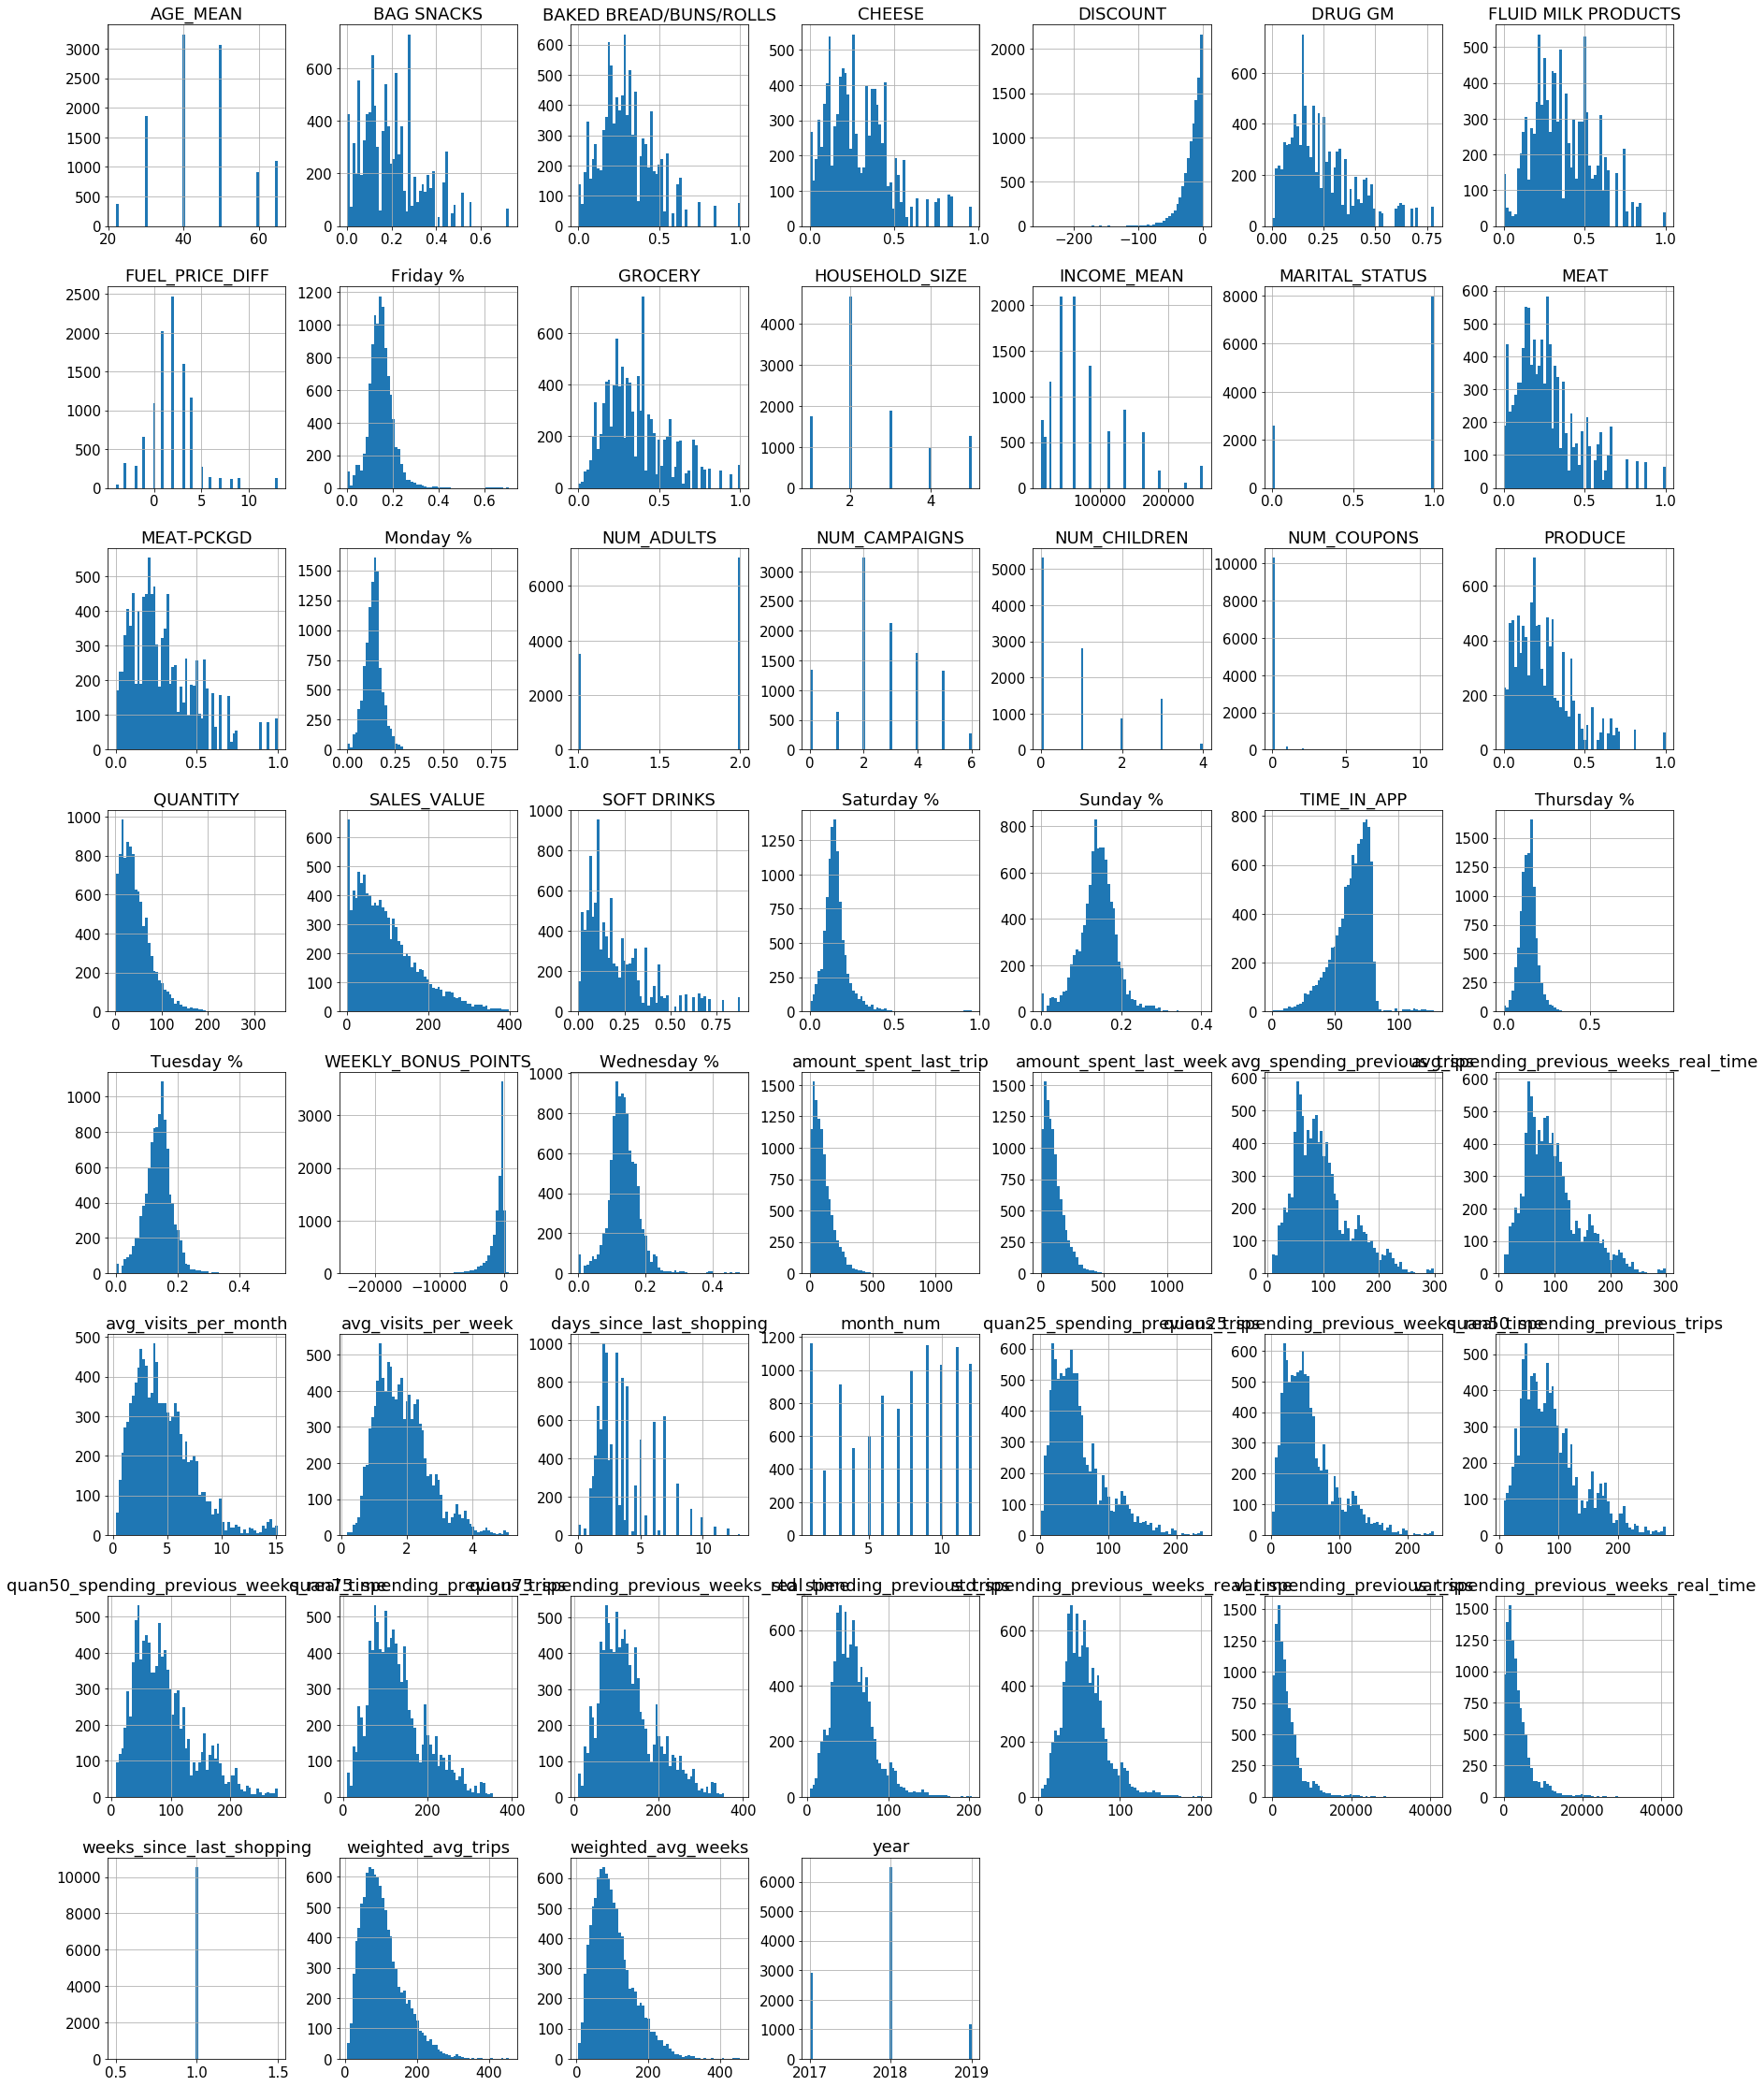

In [61]:
_ = training_data.hist(bins=61, figsize=(30,40))

In [51]:
training_data = training_data.dropna()
training_data = training_data[training_data['SALES_VALUE']<400]

# 7. Train a model <a class="anchor" id="model"></a>
[Back to top](#menu)

# 7.1. Overfit <a class="anchor" id="overfit"></a>

In [52]:
tr = training_data.copy()

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X = tr[columns_to_predict_on]
X = pd.get_dummies(X)
X = np.array(X)
polynomial_features = PolynomialFeatures(degree=2)
X = polynomial_features.fit_transform(X)
print(X.shape)

y = np.array(tr['SALES_VALUE'].tolist())

# transforming the data to include another axis

# X = X[:, np.newaxis]
y = y[:, np.newaxis]

# option 1 - temporal split
total_data = X.shape[0]
training_amount = int(total_data*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]


model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_train = model.predict(X_train)



(10556, 2415)


In [54]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_train, y_pred_train)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_train, y_pred_train)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_train, y_pred_train) 
print('R2: ' + str(r2))

mean absolute error: 17.532073085801496
mean squared error: 516.0421299318311
root mean squared error: 22.71656069768994
R2: 0.9156874962384032


In [55]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, y_pred)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, y_pred)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_test, y_pred) 
print('R2: ' + str(r2))

mean absolute error: 47.70698194204248
mean squared error: 33334.04561213303
root mean squared error: 182.57613648046402
R2: -4.885257909929612


# 7.2. Normal fit model <a class="anchor" id="normal_model"></a>

In [56]:
X = training_data[columns_to_predict_on]
X = pd.get_dummies(X)
print(X.shape)

y = training_data['SALES_VALUE']

(10556, 68)


In [57]:
# option 1 - temporal split
total_data_amount = X.shape[0]
training_amount = int(total_data_amount*0.8)

X_train = X[:training_amount]
y_train = y[:training_amount]
X_test = X[training_amount:]
y_test = y[training_amount:]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [58]:
param = {'max_depth':2, 'eta':0.7, 'booster':'gbtree', 'subsample':0.5,
         'objective':'reg:squarederror','eval_metric':'rmse'}
evallist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 250
bst = xgb.train(param, dtrain, num_round, evallist)


[0]	eval-rmse:69.8576	train-rmse:70.2039
[1]	eval-rmse:61.4044	train-rmse:61.0333
[2]	eval-rmse:60.0144	train-rmse:58.9302
[3]	eval-rmse:59.4013	train-rmse:57.946
[4]	eval-rmse:59.1397	train-rmse:57.3784
[5]	eval-rmse:58.9795	train-rmse:56.861
[6]	eval-rmse:58.248	train-rmse:56.2111
[7]	eval-rmse:57.7739	train-rmse:55.8919
[8]	eval-rmse:57.5143	train-rmse:55.4844
[9]	eval-rmse:57.4309	train-rmse:55.1596
[10]	eval-rmse:57.7122	train-rmse:54.8575
[11]	eval-rmse:58.0373	train-rmse:54.6609
[12]	eval-rmse:58.1292	train-rmse:54.5057
[13]	eval-rmse:58.4101	train-rmse:54.4259
[14]	eval-rmse:58.185	train-rmse:54.246
[15]	eval-rmse:57.9036	train-rmse:53.8383
[16]	eval-rmse:58.3531	train-rmse:53.7964
[17]	eval-rmse:57.835	train-rmse:53.2496
[18]	eval-rmse:57.751	train-rmse:53.0142
[19]	eval-rmse:57.4633	train-rmse:52.671
[20]	eval-rmse:57.6291	train-rmse:52.6714
[21]	eval-rmse:57.6241	train-rmse:52.5229
[22]	eval-rmse:57.7026	train-rmse:52.3234
[23]	eval-rmse:57.7668	train-rmse:52.0804
[24]	eval-

[195]	eval-rmse:46.8752	train-rmse:31.8371
[196]	eval-rmse:47.1542	train-rmse:31.8601
[197]	eval-rmse:46.9031	train-rmse:31.8022
[198]	eval-rmse:46.7593	train-rmse:31.7534
[199]	eval-rmse:46.8776	train-rmse:31.7273
[200]	eval-rmse:46.826	train-rmse:31.6831
[201]	eval-rmse:46.8567	train-rmse:31.5883
[202]	eval-rmse:46.8534	train-rmse:31.5583
[203]	eval-rmse:46.9828	train-rmse:31.5258
[204]	eval-rmse:47.2303	train-rmse:31.5135
[205]	eval-rmse:47.1176	train-rmse:31.486
[206]	eval-rmse:47.27	train-rmse:31.4691
[207]	eval-rmse:47.2029	train-rmse:31.353
[208]	eval-rmse:47.3425	train-rmse:31.3354
[209]	eval-rmse:47.1536	train-rmse:31.2801
[210]	eval-rmse:47.1302	train-rmse:31.2412
[211]	eval-rmse:47.1212	train-rmse:31.1634
[212]	eval-rmse:46.8102	train-rmse:31.1725
[213]	eval-rmse:46.8166	train-rmse:31.1525
[214]	eval-rmse:46.7392	train-rmse:31.0603
[215]	eval-rmse:46.7418	train-rmse:31.0212
[216]	eval-rmse:46.2641	train-rmse:30.9924
[217]	eval-rmse:46.1502	train-rmse:30.9598
[218]	eval-rmse:

### Training metrics

In [59]:

y_pred_train = bst.predict(dtrain)

mae = mean_absolute_error(y_train, y_pred_train)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_train, y_pred_train)
rmse = math.sqrt(mse)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))

r2 = r2_score(y_train, y_pred_train) 
print('R2: ' + str(r2))

mean absolute error: 23.120447182111246
mean squared error: 887.3370615830632
root mean squared error: 29.788203396362515
R2: 0.8550242218548918


### Evaluation metrics

mean absolute error: 33.51782083097507
mean squared error: 2068.9717932578415
root mean squared error: 45.485951603301004
mean absolute percentage error: 45.485951603301004
R2: 0.6347148271957741


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


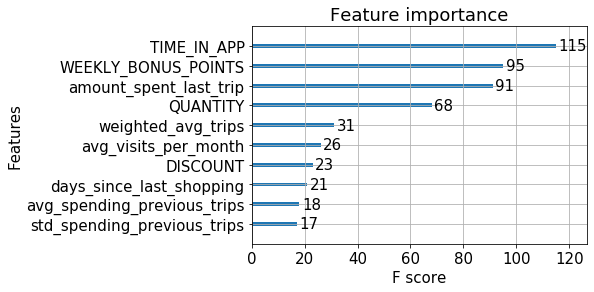

In [60]:
preds = bst.predict(dtest)
mae = mean_absolute_error(y_test, preds)
print('mean absolute error: ' + str(mae))

mse = mean_squared_error(y_test, preds)
rmse = math.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, preds)
print('mean squared error: ' + str(mse))
print('root mean squared error: ' + str(rmse))
print('mean absolute percentage error: ' + str(rmse))

r2 = r2_score(y_test, preds) 
print('R2: ' + str(r2))
matplotlib.rcParams.update({'font.size': 15})
xgb.plot_importance(bst,max_num_features=10)